#Paquetes necesarios

In [16]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la corespondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



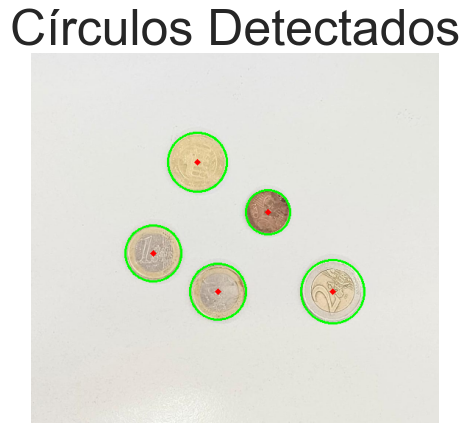

In [22]:
# Función para detectar las monedas usando HoughCircles
def detectar_monedas(img_gris):
    circ = cv2.HoughCircles(
        img_gris,  # imagen
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1, 100,  # distancia mínima entre círculos
        param1=90,  # Valor del gradiente
        param2=35,  # Umbral acumulador
        minRadius=10,  # radio mínimo
        maxRadius=150,  # radio máximo
    )
    
    if circ is not None:
        circ = np.uint16(np.around(circ))  # Redondea los valores detectados
        return circ[0, :]  # Devuelve una lista de círculos (x, y, radio)
    return []

# Función para calcular el valor total basado en el diámetro de la moneda de 1 euro
def calcular_valor_total(circulos, diametro_euro):
    total_euros = 0
    
    # Escalar los diámetros reales de las monedas en mm con respecto a 1 euro
    diametros_reales = {
        0.01: 16.25,  # 1 céntimo
        0.02: 18.75,  # 2 céntimos
        0.05: 21.25,  # 5 céntimos
        0.1: 19.75,   # 10 céntimos
        0.2: 22.25,   # 20 céntimos
        0.5: 24.25,   # 50 céntimos
        1: 23.25,     # 1 euro
        2: 25.75      # 2 euros
    }
    
    # Calcular el factor de escala con respecto a la moneda de 1 euro
    factor_escala = diametro_euro / diametros_reales[1]  # Escalar en relación al diámetro de 1 euro
    
    for circ in circulos:
        radio = circ[2]
        diametro = 2 * radio
        diametro_real = diametro / factor_escala  # Convertir el diámetro detectado a mm usando la escala

        # Determinar el valor de la moneda basada en su diámetro real
        valor_moneda = None
        for valor, diametro_ref in diametros_reales.items():
            # Si el diámetro real de la moneda está dentro de un margen razonable (±0.7 mm), asigna el valor
            if abs(diametro_real - diametro_ref) <= 0.7:
                valor_moneda = valor
                total_euros += valor
                break

        if valor_moneda is not None:
            print(f"Moneda detectada: {valor_moneda} euros. Diámetro aproximado: {diametro_real:.2f} mm")

    return total_euros

# Función para obtener el clic y calcular el valor total de las monedas
def obtener_coordenadas(event, x, y, flags, param):
    global circulos, img_bgr, total_monedas
    if event == cv2.EVENT_LBUTTONDOWN:  # Detecta clic izquierdo del mouse
        print(f"Coordenadas del clic: x={x}, y={y}")
        for circ in circulos:
            center = (circ[0], circ[1])  # Centro del círculo
            radius = circ[2]  # Radio del círculo
            distancia = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            if distancia <= radius:
                diametro_euro = 2 * radius
                print(f"Has seleccionado una moneda de 1 euro. Diámetro: {diametro_euro:.2f} píxeles")
                
                # Calcular el valor total basado en la moneda de 1 euro
                total_monedas = calcular_valor_total(circulos, diametro_euro)
                print(f"Total en la imagen: {total_monedas:.2f} euros")
                break

# Cargar la imagen
img_bgr = cv2.imread('prueba.jpeg')
img_bgr = cv2.resize(img_bgr, (0, 0), fx=0.5, fy=0.5)

# Convertir la imagen a escala de grises
img_gris = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque gaussiano para reducir el ruido
img_gris = cv2.GaussianBlur(img_gris, (5, 5), 0)

# Detectar todas las monedas en la imagen
circulos = detectar_monedas(img_gris)

# Dibujar los círculos detectados en la imagen
img_circulos = img_bgr.copy()
if len(circulos) > 0:
    for circ in circulos:
        # Dibuja el círculo en la imagen original
        cv2.circle(img_circulos, (circ[0], circ[1]), circ[2], (0, 255, 0), 2)
        # Dibuja el centro del círculo
        cv2.circle(img_circulos, (circ[0], circ[1]), 2, (0, 0, 255), 3)

# Convertir a RGB para mostrar con Matplotlib
img_rgb = cv2.cvtColor(img_circulos, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con los círculos detectados usando Matplotlib
plt.axis("off")
plt.imshow(img_rgb)
plt.title('Círculos Detectados')
plt.show()

# Inicializar el valor total
total_monedas = 0

# Asignar la función de captura de clic a la ventana
cv2.namedWindow('img')
cv2.setMouseCallback('img', obtener_coordenadas)

# Mostrar la imagen con OpenCV (en BGR)
while True:
    cv2.imshow('img', img_circulos)  # Muestra la imagen con los círculos en formato BGR
    if cv2.waitKey(20) == 27:  # Presiona 'Esc' para salir
        break

cv2.destroyAllWindows()


El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

Clasificación de microplásticos

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

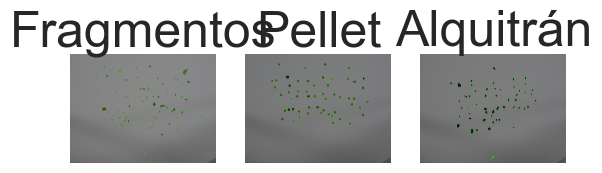

In [23]:
############### Fragmentos ###############
grayF = cv2.cvtColor(imgF, cv2.COLOR_BGR2GRAY)

umbral = 110
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1F = cv2.threshold(grayF,umbral,255,cv2.THRESH_BINARY_INV)

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1F, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada sólo contornos externos
contornos_fragmentos_filtradosF = [contour for contour in contornos2 if (cv2.contourArea(contour) >= 500 and cv2.contourArea(contour) <= 100000)]
img_rgbF = cv2.cvtColor(imgF, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgbF, contornos_fragmentos_filtradosF, -1, (0,255,0), 3)


############### Alquitran ###############
grayT = cv2.cvtColor(imgT, cv2.COLOR_BGR2GRAY)

umbralT = 100
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1T = cv2.threshold(grayT,umbralT,255,cv2.THRESH_BINARY_INV)

#Obtiene únicamente los contornos externos
contornos2T, hierarchy2 = cv2.findContours(img_th1T, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
contornos_fragmentos_filtradosT = [contourT for contourT in contornos2T if (cv2.contourArea(contourT) >= 500 and cv2.contourArea(contourT) <= 40000)]
img_rgbT = cv2.cvtColor(imgT, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgbT, contornos_fragmentos_filtradosT, -1, (0,255,0), 3)

############### Pellet ###############
grayP = cv2.cvtColor(imgP, cv2.COLOR_BGR2GRAY)

umbralP = 110
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1P = cv2.threshold(grayP,umbralP,255,cv2.THRESH_BINARY_INV)

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1P, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)
 
#Dibuja sobre la imagen de entrada sólo contornos externos
contornos_fragmentos_filtradosP = [contourP for contourP in contornos2 if (cv2.contourArea(contourP) >= 500 and cv2.contourArea(contourP) <= 500000)]
img_rgbP = cv2.cvtColor(imgP, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgbP, contornos_fragmentos_filtradosP, -1, (0,255,0), 3)


#### Areas ###
#Calcular areas fragmentos
areas_fragmentos = [cv2.contourArea(contour) for contour in contornos_fragmentos_filtradosF]


#Calcular areas fragmentos
areas_alquitran = [cv2.contourArea(contour) for contour in contornos_fragmentos_filtradosT]
#Calcular areas fragmentos
areas_pellet = [cv2.contourArea(contour) for contour in contornos_fragmentos_filtradosP]

#### Perimetros ###

# Calcular el perímetro de los contornos de Fragmentos
perimetros_fragmentos = [cv2.arcLength(contour, True) for contour in contornos_fragmentos_filtradosF]

# Calcular el perímetro de los contornos de Alquitrán
perimetros_alquitran = [cv2.arcLength(contour, True) for contour in contornos_fragmentos_filtradosT]

# Calcular el perímetro de los contornos de Pellet
perimetros_pellet = [cv2.arcLength(contour, True) for contour in contornos_fragmentos_filtradosP]

### Compacidad ###

# Calcular la compacidad de los contornos de Fragmentos
compacidad_fragmentos = [4 * np.pi * area / (perimetro ** 2) for area, perimetro in zip(areas_fragmentos, perimetros_fragmentos)]

# Calcular la compacidad de los contornos de Alquitrán
compacidad_alquitran = [4 * np.pi * area / (perimetro ** 2) for area, perimetro in zip(areas_alquitran, perimetros_alquitran)]

# Calcular la compacidad de los contornos de Pellet
compacidad_pellet = [4 * np.pi * area / (perimetro ** 2) for area, perimetro in zip(areas_pellet, perimetros_pellet)]


### Relacion area contenedor ###
#contenedor = imagen de las muestras
# Calcular el área de los contenedores (imágenes completas)
area_contenedor_F = imgF.shape[0] * imgF.shape[1]  # Área de la imagen de Fragmentos
area_contenedor_T = imgT.shape[0] * imgT.shape[1]  # Área de la imagen de Alquitrán
area_contenedor_P = imgP.shape[0] * imgP.shape[1]  # Área de la imagen de Pellet

# Calcular la relación de área para Fragmentos
relacion_area_fragmentos = [area / area_contenedor_F for area in areas_fragmentos]

# Calcular la relación de área para Alquitrán
relacion_area_alquitran = [area / area_contenedor_T for area in areas_alquitran]

# Calcular la relación de área para Pellet
relacion_area_pellet = [area / area_contenedor_P for area in areas_pellet]

############### Imagenes con contornos ###############
# Mostrar la imagen con los círculos detectados
plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgbF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgbP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(img_rgbT) 
plt.title('Alquitrán')
plt.show()

-----PELLET------
Número de contornos fragmentos: 14
Número de contornos tar: 1
Número de contornos pellet: 39
-----TAR------
Número de contornos fragmentos: 2
Número de contornos tar: 47
Número de contornos pellet: 3
-----FRAGMENT------
Número de contornos fragmentos: 25
Número de contornos tar: 5
Número de contornos pellet: 10


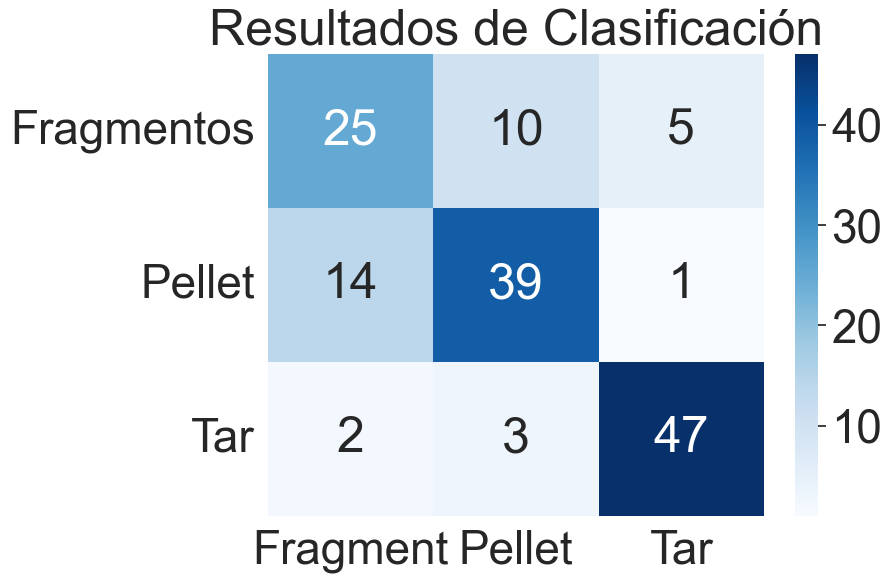

In [24]:
import math
    
def tar_classifier(list_contornos, imagen_gris):
    umbral_color_oscuro = 70
    contornos_oscuros = 0
     # Inicializa contadores
    contornos_identificados = 0
    umbral_relacion_aspecto = 0.9

    for contorno in list_contornos:
        contornos_identificados +=1
        # Calcula la relación de aspecto del contorno
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h

        # Calcula la compacidad del contorno
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad =  (4 * math.pi * area) / (perimetro ** 2)
        #print(compacidad)
        #print("Relación de aspecto = " + str(relacion_aspecto))
        
         # Comprueba si la relación de aspecto cumple con el umbral
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 1 + umbral_relacion_aspecto) and compacidad <= 0.8:
            # Recorta la región del contorno en la imagen en escala de grises
            region_contorno = imagen_gris[y:y+h, x:x+w]

            # Calcula el valor promedio de la región
            promedio = np.mean(region_contorno)

            if promedio < umbral_color_oscuro:
                contornos_oscuros += 1

    return contornos_oscuros
    
def fragment_classifier(list_contornos, imagen_gris):
    umbral_color_oscuro = 70
    fragmentos = 0
     # Inicializa contadores
    contornos_identificados = 0
    umbral_relacion_aspecto = 0.9

    for contorno in list_contornos:
        contornos_identificados +=1
        # Calcula la relación de aspecto del contorno
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h
        #print("Relacion:", relacion_aspecto)
        # Calcula la compacidad del contorno
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad =  (4 * math.pi * area) / (perimetro ** 2)
        #print(compacidad)
        #print("Relación de aspecto = " + str(relacion_aspecto))
        #print(compacidad)
         # Comprueba si la relación de aspecto cumple con el umbral
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 2 + umbral_relacion_aspecto) and compacidad < 0.6:
            # Recorta la región del contorno en la imagen en escala de grises
            region_contorno = imagen_gris[y:y+h, x:x+w]

            # Calcula el valor promedio de la región
            promedio = np.mean(region_contorno)

            if promedio > umbral_color_oscuro:
                fragmentos += 1

    return fragmentos

def pellet_classifier(list_contornos, imagen_gris):
    contornos_redondos = 0
    umbral_color_oscuro = 70
    # Define un umbral de relación de aspecto para considerar que un contorno es redondo
    umbral_relacion_aspecto = 0.2

    for contorno in list_contornos:
        # Calcula la relación de aspecto del contorno
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h
        # Calcula la compacidad del contorno
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad =  (4 * math.pi * area) / (perimetro ** 2)
        #print(compacidad)
        #print("Relación de aspecto = " + str(relacion_aspecto))
        #Comprueba si la relación de aspecto cumple con el umbral
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 1 + umbral_relacion_aspecto) and compacidad > 0.6:
           # Recorta la región del contorno en la imagen en escala de grises
            region_contorno = imagen_gris[y:y+h, x:x+w]

            # Calcula el valor promedio de la región
            promedio = np.mean(region_contorno)

            if promedio > umbral_color_oscuro:
                contornos_redondos += 1


    return contornos_redondos
print("-----PELLET------")
resultados = pellet_classifier(contornos_fragmentos_filtradosF, grayF)
print("Número de contornos fragmentos:", resultados)
resultados = pellet_classifier(contornos_fragmentos_filtradosT, grayT)
print("Número de contornos tar:", resultados)
resultados = pellet_classifier(contornos_fragmentos_filtradosP, grayP)
print("Número de contornos pellet:", resultados)
print("-----TAR------")
resultados = tar_classifier(contornos_fragmentos_filtradosF, grayF)
print("Número de contornos fragmentos:", resultados)
resultados = tar_classifier(contornos_fragmentos_filtradosT, grayT)
print("Número de contornos tar:", resultados)
resultados = tar_classifier(contornos_fragmentos_filtradosP, grayP)
print("Número de contornos pellet:", resultados)
print("-----FRAGMENT------")
resultados = fragment_classifier(contornos_fragmentos_filtradosF, grayF)
print("Número de contornos fragmentos:", resultados)
resultados = fragment_classifier(contornos_fragmentos_filtradosT, grayT)
print("Número de contornos tar:", resultados)
resultados = fragment_classifier(contornos_fragmentos_filtradosP, grayP)
print("Número de contornos pellet:", resultados)


matriz = [
    ["Fragmentos", [0, 0, 0]],
    ["Pellet", [0, 0, 0]],
    ["Tar", [0, 0, 0]]
]

# Llena la matriz con los resultados de tus clasificadores
matriz[0][1][0] = fragment_classifier(contornos_fragmentos_filtradosF, grayF)
matriz[0][1][1] = fragment_classifier(contornos_fragmentos_filtradosP, grayP)
matriz[0][1][2] = fragment_classifier(contornos_fragmentos_filtradosT, grayT)

matriz[1][1][0] = pellet_classifier(contornos_fragmentos_filtradosF, grayF)
matriz[1][1][1] = pellet_classifier(contornos_fragmentos_filtradosP, grayP)
matriz[1][1][2] = pellet_classifier(contornos_fragmentos_filtradosT, grayT)

matriz[2][1][0] = tar_classifier(contornos_fragmentos_filtradosF, grayF)
matriz[2][1][1] = tar_classifier(contornos_fragmentos_filtradosP, grayP)
matriz[2][1][2] = tar_classifier(contornos_fragmentos_filtradosT, grayT)

# Crea un DataFrame para que sea compatible con sns.heatmap()
df = pd.DataFrame({
    "Fragment": [matriz[0][1][0], matriz[1][1][0], matriz[2][1][0]],
    "Pellet": [matriz[0][1][1], matriz[1][1][1], matriz[2][1][1]],
    "Tar": [matriz[0][1][2], matriz[1][1][2], matriz[2][1][2]]
}, index=["Fragmentos", "Pellet", "Tar"])

# Muestra la matriz con sns.heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="Blues", cbar=True, fmt="d")
plt.title("Resultados de Clasificación")
plt.show()
